In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

# Loading Our Data into Our ML Algorythm #

In [2]:
# ---------------------------------------------------------
# 1. Loading ztf host galaxy csv and paper based light curve cuts. 
# ---------------------------------------------------------
df = pd.read_csv("ZTF_snia_DESI_fastspec_hostprops_with_residuals.csv")

print(len(df), "SNe in original dataset.")

df = df[(df["lccoverage_flag"] == 1) & (df["fitquality_flag"] == 1)] 

# Replace bad VDISP values with NaN

df.loc[df["VDISP"] == 125, "VDISP"] = np.nan

print("Number of VDISP replaced with NaN:",
      df["VDISP"].isna().sum())


print(len(df), "SNe after paper based quality cuts.")

# ---------------------------------------------------------
# 2. Build g - r color from SDSS absolute magnitudes
# ---------------------------------------------------------
# Note: magnitudes, so color = M_g - M_r
df["SDSS_g_minus_r"] = df["ABSMAG01_SDSS_G"] - df["ABSMAG01_SDSS_R"]

# ---------------------------------------------------------
# 2. Choose host-galaxy features + target
# ---------------------------------------------------------
candidate_features = [
    "LOGMSTAR",
    "SFR",
    "AGE",
    "DN4000",
    "VDISP",
    "SDSS_g_minus_r",
]

target_column = "residual_centered"  # what we want to predict

X = df[candidate_features]
y = df[target_column]

print(f"\nUsing {len(candidate_features)} features:", candidate_features)
print(f"Training rows after cleaning: {len(y)}")


776 SNe in original dataset.
Number of VDISP replaced with NaN: 176
579 SNe after paper based quality cuts.

Using 6 features: ['LOGMSTAR', 'SFR', 'AGE', 'DN4000', 'VDISP', 'SDSS_g_minus_r']
Training rows after cleaning: 579


Fold 1: RMSE=0.2221, NMAD=0.1755, R^2=-0.3020
Fold 2: RMSE=0.2249, NMAD=0.2114, R^2=-0.2271
Fold 3: RMSE=0.2788, NMAD=0.1922, R^2=-0.1629
Fold 4: RMSE=0.2191, NMAD=0.1738, R^2=-0.1290
Fold 5: RMSE=0.2173, NMAD=0.2079, R^2=-0.3337

[ZTF–DESI host ML] 5-fold CV summary:
  RMSE (mean) = 0.2325 mag
  NMAD (mean) = 0.1921 mag
  R^2  (mean) = -0.2309

Top features (permutation importance):
       feature  importance
         VDISP    0.302891
        DN4000    0.259551
      LOGMSTAR    0.227201
SDSS_g_minus_r    0.206349
           SFR    0.191807
           AGE    0.149369


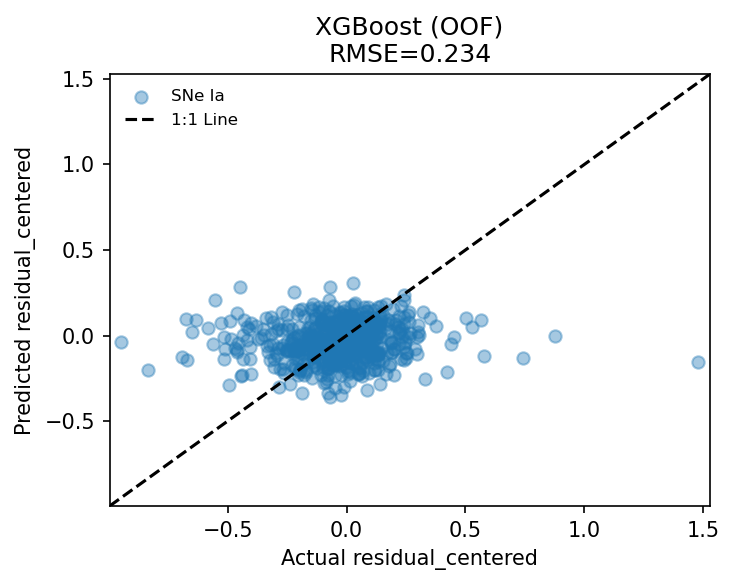


Saved OOF predictions to: /Users/pittsburghgraduatestudent/repos/first_paper_desi_match/ztf_desi_host_ml_predictions.csv


In [3]:
# ---------------------------------------------------------
# 3. Cross-validation setup
# ---------------------------------------------------------
# Creates a 5 - fold cross validation splitter. 
# Data is split into 5 parts for training and validation.
# For eah part, 4 parts are used for training and 1 part for validation.
# Shuffle is set to true to randomize the order before splitting.
# Random state is set to 42 to fix the random seed for reproducible results.

kf = KFold(n_splits=5, shuffle=True, random_state=42)


# define a function to compute Normalized Median Absolute Deviation (NMAD)
def nmad(a):
    med = np.median(a)
    return 1.4826 * np.median(np.abs(a - med))

# Defines some empty lists to store the results of each fold.
# rmses: Root Mean Square Errors
# nmads: Normalized Median Absolute Deviations
# r2s: R-squared values
# y_pred_oof: Out-of-Fold predictions (initialized with NaN values nad the same shape as y - our target column.)
rmses, nmads, r2s = [], [], []
y_pred_oof = np.full_like(y.to_numpy(), np.nan, dtype=float)

# ---------------------------------------------------------
# 4. XGBoost model - 5-fold cross-validation
# ---------------------------------------------------------
# Now this will split our candidate feature data set into training and validation sets for each fold.
# Note that the amount of splits is defined above in the KFold function.

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx] # Training, validation
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx] # Training, validation

    # Parameters of the XGBoost model. Will likely end up being setup later as hyperparameters to be tuned.
    model = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        random_state=42,
        objective="reg:squarederror",
        n_jobs=-1,
    )

    # The command to actually execute the training step of the model. 
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_pred_oof[val_idx] = y_val_pred

    resid = y_val_pred - y_val.to_numpy()
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    fold_nmad = nmad(resid)
    r2 = r2_score(y_val, y_val_pred)

    rmses.append(rmse)
    nmads.append(fold_nmad)
    r2s.append(r2)

    print(f"Fold {fold+1}: RMSE={rmse:.4f}, NMAD={fold_nmad:.4f}, R^2={r2:.4f}")

print("\n[ZTF–DESI host ML] 5-fold CV summary:")
print(f"  RMSE (mean) = {np.mean(rmses):.4f} mag")
print(f"  NMAD (mean) = {np.mean(nmads):.4f} mag")
print(f"  R^2  (mean) = {np.mean(r2s):.4f}")

# ---------------------------------------------------------
# 5. Final fit on full data + permutation importance
# ---------------------------------------------------------
final_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=42,
    objective="reg:squarederror",
    n_jobs=-1,
)

final_model.fit(X, y)

perm = permutation_importance(
    final_model,
    X,
    y,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
)

imp = pd.DataFrame({
    "feature": X.columns,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

print("\nTop features (permutation importance):")
print(imp.to_string(index=False))

# ---------------------------------------------------------
# 6. Predicted vs true plot (OOF predictions)
# ---------------------------------------------------------
mask   = ~np.isnan(y_pred_oof)
y_true = y.to_numpy()[mask]
y_pred = y_pred_oof[mask]

rmse_oof = float(np.sqrt(((y_pred - y_true) ** 2).mean()))

lo = min(y_true.min(), y_pred.min()) - 0.05
hi = max(y_true.max(), y_pred.max()) + 0.05

fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
ax.scatter(y_true, y_pred, s=35, alpha=0.4, label="SNe Ia")

ax.plot([lo, hi], [lo, hi], "--", lw=1.5, color="black", label="1:1 Line")

ax.set_xlim(lo, hi)
ax.set_ylim(lo, hi)
ax.set_xlabel("Actual residual_centered")
ax.set_ylabel("Predicted residual_centered")
ax.set_title(f"XGBoost (OOF)\nRMSE={rmse_oof:.3f}")
ax.legend(frameon=False, fontsize=8, loc="upper left")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 7. Optional: save predictions + features to CSV
# ---------------------------------------------------------
out = df.copy()
out["yhat_oof"] = y_pred_oof
out_path = Path("ztf_desi_host_ml_predictions.csv")
out.to_csv(out_path, index=False)
print(f"\nSaved OOF predictions to: {out_path.resolve()}")

In [4]:
# ---------------------------------------------------------
# 3. Cross-validation setup
# ---------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def nmad(a):
    med = np.median(a)
    return 1.4826 * np.median(np.abs(a - med))

rmses, nmads, r2s = [], [], []
outlier_rates = []          # NEW: store fold outlier fractions
y_pred_oof = np.full_like(y.to_numpy(), np.nan, dtype=float)

# ---------------------------------------------------------
# 4. XGBoost model + 5-fold CV
# ---------------------------------------------------------
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        random_state=42,
        objective="reg:squarederror",
        n_jobs=-1,
    )

    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_pred_oof[val_idx] = y_val_pred

    # prediction error (model - truth)
    resid = y_val_pred - y_val.to_numpy()

    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    fold_nmad = nmad(resid)
    r2 = r2_score(y_val, y_val_pred)

    # NEW: outliers where |error| > 0.3 mag
    fold_outlier_mask = np.abs(resid) > 0.3
    fold_outlier_rate = np.mean(fold_outlier_mask)
    outlier_rates.append(fold_outlier_rate)

    print(
        f"Fold {fold+1}: RMSE={rmse:.4f}, "
        f"NMAD={fold_nmad:.4f}, R^2={r2:.4f}, "
        f"OutlierRate(|Δ|>0.3)={fold_outlier_rate:.3f}"
    )

print("\n[ZTF–DESI host ML] 5-fold CV summary:")
print(f"  RMSE (mean)          = {np.mean(rmses):.4f} mag")
print(f"  NMAD (mean)          = {np.mean(nmads):.4f} mag")
print(f"  R^2  (mean)          = {np.mean(r2s):.4f}")
print(f"  Outlier rate (mean)  = {np.mean(outlier_rates):.3f}  (|Δ| > 0.3 mag)")

Fold 1: RMSE=0.2221, NMAD=0.1755, R^2=-0.3020, OutlierRate(|Δ|>0.3)=0.155
Fold 2: RMSE=0.2249, NMAD=0.2114, R^2=-0.2271, OutlierRate(|Δ|>0.3)=0.129
Fold 3: RMSE=0.2788, NMAD=0.1922, R^2=-0.1629, OutlierRate(|Δ|>0.3)=0.172
Fold 4: RMSE=0.2191, NMAD=0.1738, R^2=-0.1290, OutlierRate(|Δ|>0.3)=0.138
Fold 5: RMSE=0.2173, NMAD=0.2079, R^2=-0.3337, OutlierRate(|Δ|>0.3)=0.139

[ZTF–DESI host ML] 5-fold CV summary:
  RMSE (mean)          = nan mag
  NMAD (mean)          = nan mag
  R^2  (mean)          = nan
  Outlier rate (mean)  = 0.147  (|Δ| > 0.3 mag)


/Users/pittsburghgraduatestudent/miniforge3/envs/ds2/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/pittsburghgraduatestudent/miniforge3/envs/ds2/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [5]:
mask   = ~np.isnan(y_pred_oof)
y_true = y.to_numpy()[mask]
y_pred = y_pred_oof[mask]

rmse_oof = float(np.sqrt(((y_pred - y_true) ** 2).mean()))

# NEW: global outlier rate
errors = y_pred - y_true
outlier_mask = np.abs(errors) > 0.3
outlier_rate_global = np.mean(outlier_mask)
print(f"Global outlier rate (|Δ| > 0.3 mag): {outlier_rate_global:.3f}")

Global outlier rate (|Δ| > 0.3 mag): 0.147


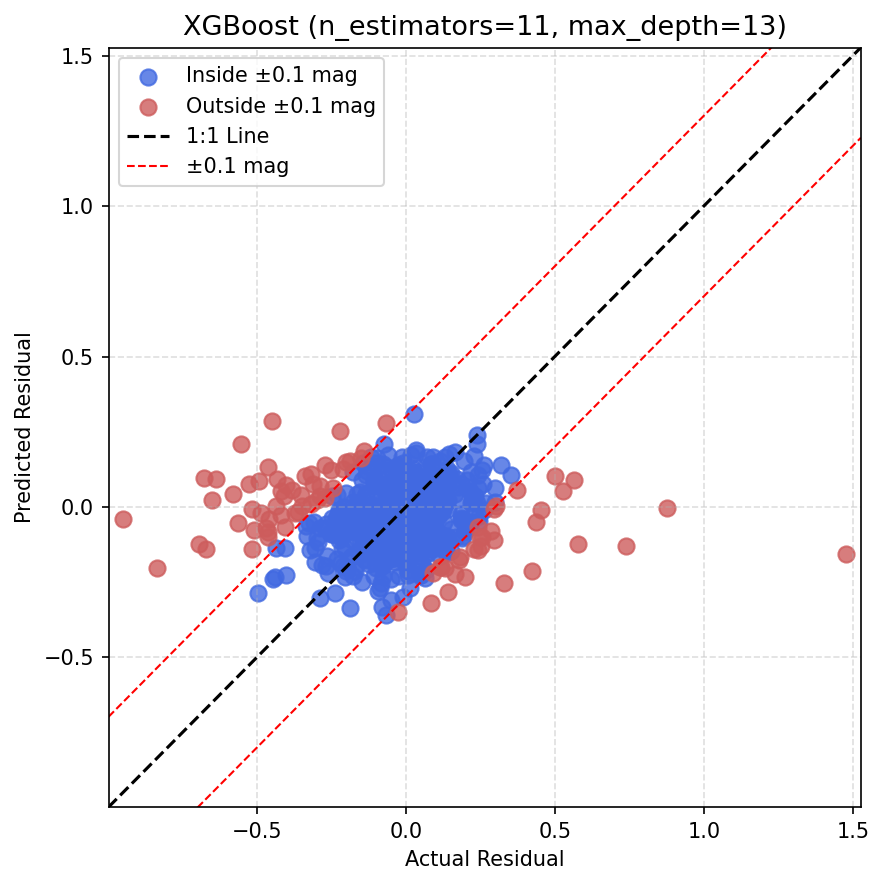

In [6]:
# ---------------------------------------------------------
# 6. Predicted vs true plot (OOF predictions) — styled version
# ---------------------------------------------------------

mask   = ~np.isnan(y_pred_oof)
y_true = y.to_numpy()[mask]
y_pred = y_pred_oof[mask]

errors = y_pred - y_true

# Define ±0.1 mag tolerance lines
tol = 0.3

# Color points: blue inside ±0.1 mag, red outside
inside_mask = np.abs(errors) <= tol
outside_mask = ~inside_mask

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

# Plot inside-tolerance points
ax.scatter(
    y_true[inside_mask], y_pred[inside_mask], 
    color='royalblue', s=60, alpha=0.8, label="Inside ±0.1 mag"
)

# Plot outside-tolerance points
ax.scatter(
    y_true[outside_mask], y_pred[outside_mask], 
    color='indianred', s=60, alpha=0.8, label="Outside ±0.1 mag"
)

# 1:1 line
lo = min(y_true.min(), y_pred.min()) - 0.05
hi = max(y_true.max(), y_pred.max()) + 0.05
ax.plot([lo, hi], [lo, hi], 'k--', linewidth=1.5, label="1:1 Line")

# ±0.1 mag dashed red lines
ax.plot([lo, hi], [lo+tol, hi+tol], 'r--', linewidth=1, label="±0.1 mag")
ax.plot([lo, hi], [lo-tol, hi-tol], 'r--', linewidth=1)

# Labels, title, grid
ax.set_xlabel("Actual Residual")
ax.set_ylabel("Predicted Residual")
ax.set_xlim(lo, hi)
ax.set_ylim(lo, hi)

ax.set_title("XGBoost (n_estimators=11, max_depth=13)", fontsize=13)
ax.grid(True, alpha=0.4, linestyle='--')

ax.legend(frameon=True)
plt.tight_layout()
plt.show()

In [7]:
# ---------------------------------------------------------
# Sweep n_estimators and track stats (RMSE, NMAD, outlier rate)
# ---------------------------------------------------------

n_estimators_list = np.arange(50, 801, 50)  # e.g. 50, 100, ..., 800
rmse_list = []
nmad_list = []
outlier_rate_list = []

outlier_thresh = 0.1  # mag

for n_estimators in n_estimators_list:
    # OOF predictions for this choice of n_estimators
    y_pred_oof = np.full_like(y.to_numpy(), np.nan, dtype=float)

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            reg_alpha=0.0,
            random_state=42,
            objective="reg:squarederror",
            n_jobs=-1,
        )

        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)

        y_pred_oof[val_idx] = y_val_pred

    # Now compute stats using all OOF predictions
    y_true = y.to_numpy()
    resid = y_pred_oof - y_true

    rmse = np.sqrt(np.mean(resid**2))
    nmad_val = nmad(resid)
    outlier_rate = 100.0 * np.mean(np.abs(resid) > outlier_thresh)

    rmse_list.append(rmse)
    nmad_list.append(nmad_val)
    outlier_rate_list.append(outlier_rate)

rmse_array    = np.array(rmse_list)
nmad_array    = np.array(nmad_list)
outlier_array = np.array(outlier_rate_list)

best_rmse_idx    = np.argmin(rmse_array)
best_nmad_idx    = np.argmin(nmad_array)
best_outlier_idx = np.argmin(outlier_array)

print("=== Best values over n_estimators grid ===")
print(f"  Best RMSE         at n_estimators={n_estimators_list[best_rmse_idx]}: {rmse_array[best_rmse_idx]:.4f}")
print(f"  Best NMAD         at n_estimators={n_estimators_list[best_nmad_idx]}: {nmad_array[best_nmad_idx]:.4f}")
print(f"  Best Outlier rate at n_estimators={n_estimators_list[best_outlier_idx]}: {outlier_array[best_outlier_idx]:.2f}%")

=== Best values over n_estimators grid ===
  Best RMSE         at n_estimators=50: 0.2128
  Best NMAD         at n_estimators=50: 0.1710
  Best Outlier rate at n_estimators=50: 54.75%


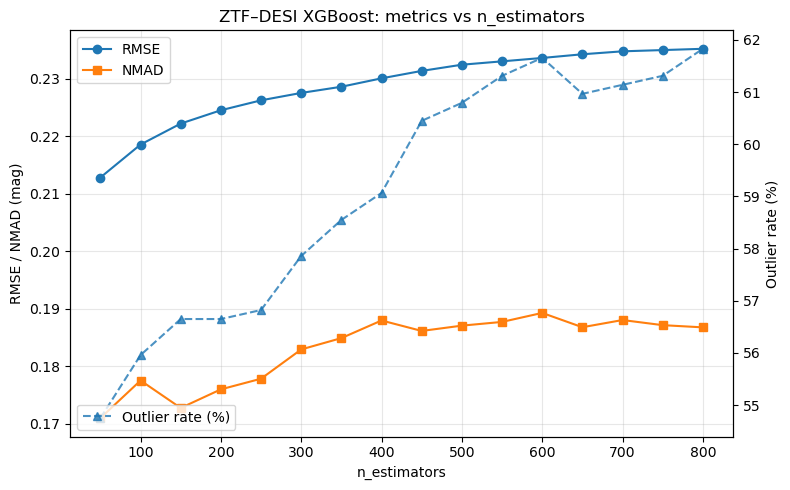

In [14]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# Left axis: RMSE and NMAD
ax1.set_xlabel("n_estimators")
ax1.set_ylabel("RMSE / NMAD (mag)")
ax1.plot(n_estimators_list, rmse_array, marker="o", label="RMSE")
ax1.plot(n_estimators_list, nmad_array, marker="s", label="NMAD")
ax1.grid(True, alpha=0.3)
ax1.legend(loc="upper left")

# Right axis: outlier rate
ax2 = ax1.twinx()
ax2.set_ylabel("Outlier rate (%)")
ax2.plot(n_estimators_list, outlier_array, marker="^", linestyle="--", label="Outlier rate (%)", alpha=0.8)
ax2.legend(loc="lower left")

plt.title("ZTF–DESI XGBoost: metrics vs n_estimators")
fig.tight_layout()
plt.show()